In [1]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [2]:
import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras 

Segmentation Models: using `tf.keras` framework.


In [3]:
#from keras.utils import normalize
from keras.utils.np_utils import normalize
from keras.metrics import MeanIoU

In [4]:
#Resizing images, if needed
SIZE_X = 128 
SIZE_Y = 128
#n_classes=5

In [5]:
#Capture training image info as a list
train_images = []

for directory_path in glob.glob("saroadscenes_data/Images_128"):
    for img_path in glob.glob(os.path.join(directory_path, "*.tiff")):
        img = cv2.imread(img_path, 1)       
        train_images.append(img)
       
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

In [6]:
#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob("saroadscenes_data/Masks_128"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.tiff")):
        mask = cv2.imread(mask_path, 0)       
        train_masks.append(mask)
        
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

In [7]:
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


array([0, 1, 2, 3, 4, 5], dtype=int64)

In [8]:
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

In [9]:
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

#Further split training data t a smaller subset for quick testing
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.5, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 

Class values in the dataset are ...  [0 1 2 3 4 5]


In [10]:
from keras.utils.np_utils import to_categorical

n_classes=6

train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [11]:
#Reused parameters in all models

n_classes=6
activation='softmax'

LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

#dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25])) 
#focal_loss = sm.losses.CategoricalFocalLoss()
#total_loss = dice_loss + (1 * focal_loss)

#Total_loss can be imported directly from library
total_loss = sm.losses.binary_focal_dice_loss

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]


In [12]:
#Inceptionv3
BACKBONE2 = 'inceptionv3'
preprocess_input2 = sm.get_preprocessing(BACKBONE2)

In [13]:
#Preprocess input
X_train2 = preprocess_input2(X_train)
X_test2 = preprocess_input2(X_test)

In [14]:
#Define model
model2 = sm.Unet(BACKBONE2, encoder_weights='imagenet', classes=n_classes, activation=activation)

In [15]:
#Compile keras model with defined optimozer, loss and metrics
model2.compile(optim, total_loss, metrics=metrics)

In [16]:
print(model2.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [17]:
history2=model2.fit(X_train2, 
          y_train_cat,
          batch_size=8, 
          epochs=50,
          verbose=1,
          validation_data=(X_test2, y_test_cat))

Epoch 1/50
56/56 [==============================] - 61s 954ms/step - loss: 0.8196 - iou_score: 0.1075 - f1-score: 0.1676 - val_loss: 0.7776 - val_iou_score: 0.1960 - val_f1-score: 0.2906
Epoch 2/50
56/56 [==============================] - 53s 947ms/step - loss: 0.6792 - iou_score: 0.3225 - f1-score: 0.4199 - val_loss: 0.7246 - val_iou_score: 0.2967 - val_f1-score: 0.3731
Epoch 3/50
56/56 [==============================] - 52s 931ms/step - loss: 0.6121 - iou_score: 0.3942 - f1-score: 0.4815 - val_loss: 0.6154 - val_iou_score: 0.3739 - val_f1-score: 0.4516
Epoch 4/50
56/56 [==============================] - 53s 956ms/step - loss: 0.5686 - iou_score: 0.4310 - f1-score: 0.5131 - val_loss: 0.5774 - val_iou_score: 0.4102 - val_f1-score: 0.4854
Epoch 5/50
56/56 [==============================] - 53s 949ms/step - loss: 0.5372 - iou_score: 0.4491 - f1-score: 0.5269 - val_loss: 0.5604 - val_iou_score: 0.4190 - val_f1-score: 0.4939
Epoch 6/50
56/56 [==============================] - 53s 943ms/ste

Epoch 45/50
56/56 [==============================] - 53s 955ms/step - loss: 0.2599 - iou_score: 0.6989 - f1-score: 0.7785 - val_loss: 0.4369 - val_iou_score: 0.5558 - val_f1-score: 0.6593
Epoch 46/50
56/56 [==============================] - 53s 940ms/step - loss: 0.2583 - iou_score: 0.6967 - f1-score: 0.7740 - val_loss: 0.4309 - val_iou_score: 0.5637 - val_f1-score: 0.6665
Epoch 47/50
56/56 [==============================] - 53s 949ms/step - loss: 0.2546 - iou_score: 0.7029 - f1-score: 0.7840 - val_loss: 0.4325 - val_iou_score: 0.5661 - val_f1-score: 0.6725
Epoch 48/50
56/56 [==============================] - 53s 946ms/step - loss: 0.2537 - iou_score: 0.7030 - f1-score: 0.7820 - val_loss: 0.4309 - val_iou_score: 0.5650 - val_f1-score: 0.6694
Epoch 49/50
56/56 [==============================] - 52s 938ms/step - loss: 0.2522 - iou_score: 0.7052 - f1-score: 0.7830 - val_loss: 0.4377 - val_iou_score: 0.5595 - val_f1-score: 0.6649
Epoch 50/50
56/56 [==============================] - 53s 942

In [18]:
model2.save('inceptionv3_backbone_50epochs_saroadscenes.hdf5')

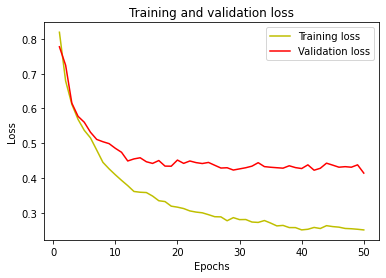

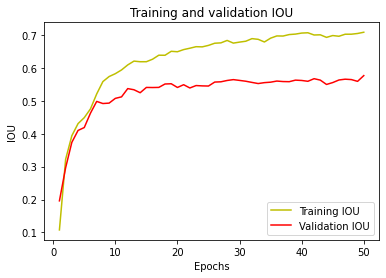

In [19]:
#plot the training and validation accuracy and loss at each epoch
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history2.history['iou_score']
val_acc = history2.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [16]:
from keras.models import load_model

#Set compile=False as we are not loading it for training, only for prediction.
model2 = load_model('inceptionv3_backbone_50epochs_saroadscenes.hdf5', compile=False)

In [20]:
#IOU
y_pred2=model2.predict(X_test2)
y_pred2_argmax=np.argmax(y_pred2, axis=3)

In [21]:
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred2_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.6092914


In [22]:
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)

[[330173.  13530.   2295.   2302.  24485.  12429.]
 [ 17257.  66378.    907.   1100.   6828.   7428.]
 [ 12615.    951.  47763.   1718.  11786.   4163.]
 [  5293.    741.    638.   6235.   2971.   6498.]
 [ 26073.   2445.   4497.   1684. 416235.   5987.]
 [ 18786.   8785.   1058.   5532.   2650. 525416.]]


In [23]:
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[0,4] + values[0,5] + values[1,0] + values[2,0] + values[3,0] + values[4,0] + values[5,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[1,4] + values[1,5] + values[0,1] + values[2,1] + values[3,1] + values[4,1] + values[5,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[2,4] + values[2,5] + values[0,2] + values[1,2] + values[3,2] + values[4,2] + values[5,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[3,4] + values[3,5] + values[0,3] + values[1,3] + values[2,3] + values[4,3] + values[5,3])
class5_IoU = values[4,4]/(values[4,4] + values[4,0] + values[4,1] + values[4,2] + values[4,3] + values[4,5] + values[0,4] + values[1,4] + values[2,4] + values[3,4] + values[5,4])
class6_IoU = values[5,5]/(values[5,5] + values[5,0] + values[5,1] + values[5,2] + values[5,3] + values[5,4] + values[0,5] + values[1,5] + values[2,5] + values[3,5] + values[4,5])

In [24]:
print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)
print("IoU for class5 is: ", class5_IoU)
print("IoU for class6 is: ", class6_IoU)

IoU for class1 is:  0.7096862
IoU for class2 is:  0.5253502
IoU for class3 is:  0.54036045
IoU for class4 is:  0.17962088
IoU for class5 is:  0.8231828
IoU for class6 is:  0.87754786


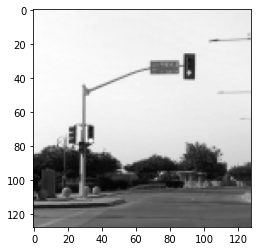

In [25]:
#Varify the prediction on first image
plt.imshow(train_images[0, :,:,0], cmap='gray')

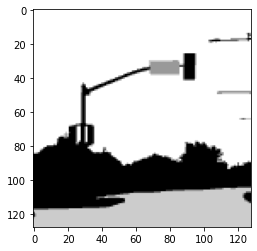

In [26]:
plt.imshow(train_masks[0], cmap='gray')

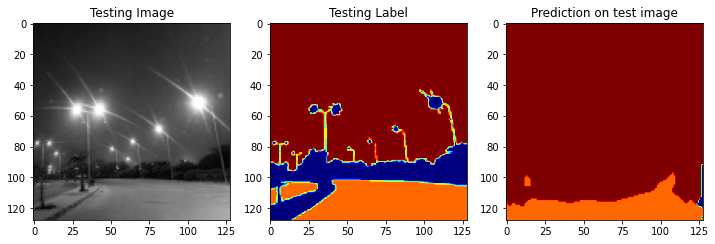

In [29]:
#Test some random images
import random
test_img_number = random.randint(0, len(X_test2))
test_img = X_test2[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input2 = preprocess_input2(test_img_input)

test_pred2 = model2.predict(test_img_input2)
test_prediction2 = np.argmax(test_pred2, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction2, cmap='jet')
plt.show()